# Notebook 4: The Geometry Bridge – Understanding GALE

---

## Learning Objectives

By the end of this notebook, you will:

1. **Understand** the fundamental challenges of building AI surrogates for industrial CFD
2. **Recognize** why standard deep learning architectures struggle to maintain geometric awareness
3. **Visualize** representation drift and its impact on prediction accuracy
4. **Master** the GALE mechanism that makes GeoTransolver effective
5. **Connect** architectural innovations to practical aerodynamic applications

---

## 1. Introduction: The Challenge of AI for Industrial CFD

### 1.1 The Promise of AI Surrogates

Computer-Aided Engineering (CAE) is undergoing a transformation. Traditional high-fidelity CFD simulations—while accurate—can take **hours to days** per design iteration. This creates a bottleneck in the design exploration process, where engineers need to evaluate hundreds or thousands of candidate geometries.

**AI-based surrogate models** promise to change this paradigm:

| Metric | Traditional CFD | AI Surrogate | Speedup |
|--------|-----------------|--------------|---------|
| Time per evaluation | Hours to days | Seconds to minutes | 100-1000× |
| Design iterations/week | ~10-50 | ~1000+ | 20-100× |
| Hardware requirements | HPC clusters | Single GPU | Significant reduction |

However, achieving this promise requires overcoming several fundamental challenges that have limited existing approaches.

---

### 1.2 Why Building Reliable Physics-AI Is Hard

Real-world engineering problems present a unique combination of difficulties:

#### **Challenge 1: Geometric Complexity**

Real-world geometries are **heterogeneous and irregular** with multiscale features. A car body includes smooth surfaces, sharp edges, complex wheel wells, mirrors, and underbody details—all of which influence the flow field differently.

```text
   Fine details          Medium features          Global shape
  ┌─────────┐          ┌─────────────┐          ┌─────────────────┐
  │ • Edges │          │ • Curvature │          │ • Overall form  │
  │ • Gaps  │    +     │ • Features  │    +     │ • Wake region   │
  │ • Seams │          │ • Openings  │          │ • Far-field     │
  └─────────┘          └─────────────┘          └─────────────────┘
       ↓                      ↓                          ↓
 Flow separation      Pressure gradients        Drag & lift forces
```

#### **Challenge 2: Nonlinear Physics with Long-Range Dependencies**

Local effects—such as boundary layer separation at a sharp edge—can produce **long-range dependencies** that span the entire computational domain. A small geometric change near the front of a vehicle can dramatically alter the wake structure meters downstream.

#### **Challenge 3: Regime Sensitivity**

Physical behavior changes dramatically with operating conditions:
- **Reynolds number**: Laminar vs. turbulent flow
- **Mach number**: Subsonic vs. transonic (shock formation)
- **Angle of attack**: Attached vs. separated flow

Models must **encode and respect** these physical regimes and boundary conditions efficiently.

#### **Challenge 4: Data Scarcity and Domain Shift**

High-fidelity simulations are expensive, making datasets inherently limited. Additionally:
- Training data may be biased by specific solver settings
- Domain shifts occur across different shape families (sedans vs. SUVs vs. aircraft)
- Generalization to unseen geometries remains difficult

#### **Challenge 5: Layer-wise Error Accumulation**

Deep neural networks can **accumulate error layer-by-layer**, particularly in stiff regimes where small perturbations grow rapidly. This manifests as "representation drift"—a phenomenon we will explore in detail in this notebook.

---

### 1.3 The Limitation of Existing Approaches

Let's briefly survey how current methods address (or fail to address) these challenges:

| Approach | Strengths | Limitations |
|----------|-----------|-------------|
| **FNO** (Fourier Neural Operator) | Efficient global mixing via spectral convolution | Struggles with irregular domains; requires structured grids |
| **GNO** (Graph Neural Operator) | Handles irregular meshes via message passing | Local interactions only; limited long-range coupling |
| **MeshGraphNet** | Respects mesh topology | Computational cost scales poorly with mesh size |
| **Transolver** | Physics-aware attention; handles unstructured data | Geometry context can fade in deep layers |
| **DoMINO** | Multi-scale ball queries; good generalization | Context not persistently maintained at depth |

> **The Gap:** While each approach excels in certain aspects, none fully addresses the combination of geometric complexity, long-range physics, regime sensitivity, AND deep network stability simultaneously.

---

### 1.4 Enter GeoTransolver

**GeoTransolver** is designed to address this gap. It extends the Transolver architecture with innovations specifically targeting the challenges outlined above:

| Challenge | GeoTransolver Solution |
|-----------|------------------------|
| Geometric complexity | Multi-scale ball queries capture features at all scales |
| Long-range dependencies | Transformer attention enables nonlocal coupling |
| Regime sensitivity | Global parameters injected as persistent context |
| Deep network stability | **GALE attention** maintains geometric awareness at every layer |

The key innovation is **GALE (Geometry-Aware Latent Embeddings)**—a novel attention mechanism that we will explore in depth in Section 3.

---

### 1.5 Key Contributions (Overview)

GeoTransolver introduces three architectural innovations:

| Contribution | What It Does | Problem It Solves |
|--------------|--------------|-------------------|
| **GALE Attention** | Pairs physics-aware self-attention with cross-attention to geometry context | Prevents "forgetting" of geometric features in deep layers |
| **Persistent Context Projection** | Injects geometry and global features into every transformer block | Reduces layer-wise drift; improves stability |
| **Multi-Scale Ball Queries** | Captures local and global geometric information at multiple radii | Balances boundary-layer fidelity with far-field coupling |

> **Section 3** will provide a detailed walkthrough of how GALE works. First, let's understand the broader context and visualize the problem it solves.

---

### 1.6 Notebook Roadmap

| Section | Topic | Focus |
|---------|-------|-------|
| **2** | Background & Related Work | Where GeoTransolver fits in the AI-for-science landscape |
| **3** | The GALE Mechanism | Detailed architecture walkthrough (Core of this notebook) |
| **4** | Representation Drift | Visualizing why GALE matters |
| **5** | Interactive Demonstration | Hands-on exploration with Ahmed Body geometry |
| **6** | Results Interpretation | Understanding visualization outputs |
| **7** | Summary & Next Steps | Connecting to training notebooks |

---

### 1.7 Prerequisites

Before proceeding, ensure familiarity with:

| Prerequisite | Notebooks |
|--------------|-----------|
| ✅ Transformer fundamentals (attention mechanisms) | General ML background |
| ✅ Transolver architecture | Notebooks 1-3 of this series |

---

> **Let's Begin:** In Section 2, we explore the landscape of neural operators and position GeoTransolver relative to state-of-the-art approaches. Then, in Section 3, we dive deep into the GALE mechanism—the heart of GeoTransolver's innovation.

---

*Reference: Content based on "GeoTransolver: Learning Physics on Irregular Domains using Multi-scale Geometry Aware Physics Attention Transformer" (ICML 2025)* — [GeoTransolver_ICML-komprimiert.pdf]




---

## 2. The Problem: Representation Drift in Deep Networks

### 2.1 What Happens Inside a Deep Transformer?

When data flows through a deep neural network, each layer transforms the input representation:

$$H^{(\ell)} = \text{Layer}_\ell\left(H^{(\ell-1)}\right)$$

Where $H^{(\ell)}$ is the hidden representation at layer $\ell$. Each layer applies attention, normalization, and feedforward operations to transform the features to solve the physics.

### 2.2 The "Telephone Game" Analogy

Representation drift is like the children's game of **"Telephone"**:

| Layer | What the Network "Remembers" |
| :--- | :--- |
| **Layer 0** | *"I am a point on the side mirror at position (x, y, z)"* |
| **Layer 10** | *"I am associated with a high-pressure region"* |
| **Layer 20** | *"I am a generic fluid particle"* |
| **Layer 30** | *"I am... something?"* ❌ (Geometric context is lost) |

> *"Since the inputs to each physics attention layer are the outputs of the previous layer only, there is no 'recall' ability for fine-grained attending to encode geometrical features."*
> — *GeoTransolver Paper (ICML 2025)*

### 2.3 Why Does This Matter for CFD?

In Computational Fluid Dynamics, geometric features directly determine flow physics:

| Geometric Feature | Physical Significance | Consequence if "Forgotten" |
| :--- | :--- | :--- |
| **Sharp edges** | Flow separation points | Incorrect wake prediction |
| **Surface curvature** | Pressure gradients | Wrong lift/drag estimates |
| **No-Slip Walls** | Boundary Conditions | Fluid passing through solid objects |

**Bottom line:** If the network forgets geometry in deep layers, it cannot enforce boundary conditions, making predictions unreliable.

---

## 3. GeoTransolver: The GALE Mechanism Simplified

### 3.1 The Core Idea: Persistent Geometry Conditioning

Standard neural networks for physics simulation face a fundamental limitation:

> *"Since the inputs to each physics attention layer are the outputs of the previous layer only, there is no 'recall' ability for fine-grained attending to encode geometrical features."*
> — GeoTransolver Paper (ICML 2025)

**GeoTransolver's Solution:** Instead of injecting geometry only at the input, GeoTransolver maintains a **persistent geometry context** that is accessible at **every layer** through a mechanism called **GALE (Geometry-Aware Latent Embeddings)**.

Think of GALE as the network's **"GPS system"**:
- In standard deep networks, the model can "get lost" as it processes many layers (Representation Drift)
- GALE ensures that no matter how deep the network goes, it always knows **exactly what shape** it is simulating


```mermaid
graph LR
    subgraph Standard ["STANDARD TRANSOLVER"]
    direction LR
    G(Geometry) --> I[Input]
    I --> L1(Layer 1)
    L1 --> L2(Layer 2)
    L2 --> Dots(...)
    Dots --> O[Output]
    
    style G fill:#f96,stroke:#333
    style I fill:#fff,stroke:#333
    end
```
```mermaid
graph TD
    subgraph Geo ["GEOTRANSOLVER (GALE)"]
    C[<b>Geometry Context - C</b><br/>Always-On GPS Signal]
    I[Input] --> L1(Layer 1)
    L1 --> L2(Layer 2)
    L2 --> L3(Layer 3)
    L3 --> O[Output]

    C -.->|GALE Recall| L1
    C -.->|GALE Recall| L2
    C -.->|GALE Recall| L3
    
    style C fill:#00c8ff,stroke:#000,color:#fff
    style I fill:#fff,stroke:#333
    end
```

<div align="center">
    <img src="./fig/fig1_gale_concept.png" width="80%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>


---

### 3.2 The Geometry Context: What Does the Network "Remember"?

Before understanding how GALE works, we need to know what information is stored in the **Geometry Context (C)**:

| Component | Description | Why It Matters |
|-----------|-------------|----------------|
| **Multi-scale geometry features** | Surface details captured at multiple resolutions via ball queries | Captures both fine details (edges) and global shape |
| **Global parameters** | Reynolds number, Mach number, angle of attack | Defines the flow regime |
| **Boundary information** | Inlet/outlet conditions, wall types | Specifies physical constraints |

The context $C$ is built **once** at the beginning and then **reused** at every GALE layer—this is what makes it "persistent."

---

### 3.3 How GALE Works: The 3-Step Process

Think of each GALE layer as a specialist that performs three tasks in sequence:


#### **Step 1: Physics Evolution (Self-Attention)**

The model examines how physical quantities (pressure, velocity) evolve based on interactions between spatial locations:

$$SA^{(\ell)}_m = \text{Attention}\left(H^{(\ell-1)} W_Q,\ H^{(\ell-1)} W_K,\ H^{(\ell-1)} W_V\right)$$

**Intuition:** *"Based on the current flow state, how should pressure and velocity change at each point?"*

This is similar to standard Transolver—the network learns physical dynamics through attention.


#### **Step 2: Geometry Recall (Cross-Attention)**

The model "checks back" with the original blueprint by querying the persistent geometry context:

$$CA^{(\ell)}_m = \text{Attention}\left(H^{(\ell-1)} W_{Q,c},\ C \cdot W_{K,c},\ C \cdot W_{V,c}\right)$$

**Intuition:** *"Does my current physics prediction still respect the actual physical geometry? Where are the walls, edges, and curves?"*

| Attention Type | Query Source | Key/Value Source | Purpose |
|----------------|--------------|------------------|---------|
| Self-Attention | Current state $$H^{(\ell-1)}$$ | Current state $$H^{(\ell-1)}$$ | Physics evolution |
| Cross-Attention | Current state $$H^{(\ell-1)}$$ | Geometry context $$C$$ | Geometry recall |


#### **Step 3: Smart Mixing (Adaptive Gating)**

The model uses a **learned gate** $\alpha$ to blend the physics update with the geometry recall:

$$\alpha^{(\ell)} = \sigma\left(\eta\left(\text{Pool}(SA^{(\ell)}),\ \text{Pool}(C)\right)\right)$$

$$H^{(\ell)} = (1 - \alpha^{(\ell)}) \cdot SA^{(\ell)} + \alpha^{(\ell)} \cdot CA^{(\ell)}$$

Where:
- $\alpha^{(\ell)} \in (0, 1)$ = Learned mixing coefficient
- $\sigma$ = Sigmoid function (ensures output between 0 and 1)
- $\eta$ = Small MLP that learns when to emphasize geometry vs physics

**Intuition:** *"At this specific location and layer depth, should I trust my physics calculation more, or do I need to double-check the geometry?"*

---

### 3.4 The Key Insight: Why "Adaptive" Gating is Powerful
The gate $\alpha$ is **not a fixed number**—it's a **learned, spatially-varying switch** that adapts based on:

1. **Where** on the surface (complex vs simple regions)
2. **How deep** in the network (early vs late layers)
3. **What** the current physical state looks like

| Region Type | Gate (α) Behavior | Physical Reasoning |
| :--- | :--- | :--- |
| **Complex geometry**<br>(mirrors, spoilers) | **High α** | Sharp details create flow separation; model needs constant geometry reminders. |
| **Flat surfaces**<br>(roof, underbody) | **Low α** | Simple geometry; model can focus primarily on physics evolution. |
| **Wake regions**<br>(behind vehicle) | **Moderate α** | No surface nearby, but wake structure depends on upstream geometry. |

```mermaid
graph TD
    subgraph HighAlpha ["HIGH α (Geometry-focused)"]
        direction LR
        C1[<b>Complex Regions</b>] --- M(Side mirror, Spoiler)
        C1 --> R[<b>Action:</b> High Recall]
        R -.->|Pulls from| G(Geometry Blueprint)
        style HighAlpha fill:#fff4f4,stroke:#e66,stroke-width:2px
    end

    subgraph LowAlpha ["LOW α (Physics-focused)"]
        direction LR
        C2[<b>Simple Regions</b>] --- F(Flat roof, Hood)
        C2 --> P[<b>Action:</b> High Physics]
        P -.->|Trusts| L(Fluid Evolution)
        style LowAlpha fill:#f4f9ff,stroke:#66a,stroke-width:2px
    end
```

<div align="center">
    <img src="./fig/fig2_gate_behaviour.png" width="100%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>


---

### 3.5 Why This Matters for Industrial CFD

The adaptive gating mechanism provides three critical benefits:

| Benefit | Explanation | Impact |
|---------|-------------|--------|
| **Bounded Error** | Continuous geometry re-injection prevents unbounded drift | More accurate predictions at all network depths |
| **Efficient Computation** | Low $$\alpha$$ regions skip heavy geometry processing | Faster inference without sacrificing accuracy |
| **Better Generalization** | Persistent conditioning improves extrapolation to new shapes | Works on car designs not seen during training |

> **The Result:** By re-injecting geometry at every layer with adaptive strength, GeoTransolver maintains a **bounded representation error**, making it significantly more accurate for industrial CFD applications than models that only process geometry once at the input.

---

### 3.6 Summary: The GALE Mechanism at a Glance

Each GALE layer acts as a specialized processing unit that balances physical simulation with geometric grounding.

```mermaid
graph LR
    In[Input: H ℓ-1] --> SA[Self-Attention<br/>Physics Evolution]
    In --> CA[Cross-Attention<br/>Geometry Recall]
    
    SA --> Gate{Gate α}
    CA --> Gate
    
    Gate --> Mix[H ℓ = 1-α SA + α CA]
    Mix --> Out[Output: H ℓ]
    
    style Gate fill:#f9f,stroke:#333
    style Mix fill:#dfd,stroke:#333
```

<div align="center">
    <img src="./fig/fig3_gale_layer.png" width="50%" />
    <p style="margin-top: 10px; font-size: 0.95em;">
    </p>
</div>

**Key Equations Summary:**

| Step | Equation | Purpose |
|------|----------|---------|
| Self-Attention | $$SA^{(\ell)} = \text{Attn}(H W_Q, H W_K, H W_V)$$ | Physics evolution |
| Cross-Attention | $$CA^{(\ell)} = \text{Attn}(H W_{Q,c}, C W_{K,c}, C W_{V,c})$$ | Geometry recall |
| Adaptive Gate | $$\alpha^{(\ell)} = \sigma(\eta(\text{Pool}(SA), \text{Pool}(C)))$$ | Smart mixing |
| Output | $$H^{(\ell)} = (1-\alpha) \cdot SA + \alpha \cdot CA$$ | Combined result |


## 4. Visualizing Representation Drift: A Demonstration

### 4.1 What We Will Show

To build intuition for **representation drift**, we construct a **simplified, controlled simulation** based on the *Ahmed Body* geometry. The goal is not numerical accuracy, but **conceptual clarity**: to visually illustrate how geometric representations can progressively degrade—or remain stable—across layers.

| Experiment | Method | Expected Outcome |
|------------|--------|------------------|
| **Case A** | Standard Transolver (simulated) | Geometry gradually degrades layer by layer |
| **Case B** | GeoTransolver with GALE (simulated) | Global structure remains preserved throughout |

To quantify drift, we compute the **Mean Squared Error (MSE)** between the original geometry and the geometry after each simulated layer.

---

### 4.2 ⚠️ Important: Simulation vs. Reality

> **The visualization below is a pedagogical abstraction designed to build intuition. It does _not_ represent actual neural network training or learned model behavior.**

| Aspect | Our Simulation | Real GeoTransolver Training |
|--------|----------------|----------------------------|
| **Source of drift** | Explicit Gaussian noise added to coordinates | Implicit drift from learned weight updates and attention operations |
| **Perturbation scale** | Deliberately exaggerated (σ = 0.08 per layer) for visibility | Much smaller, accumulated changes during optimization |
| **GALE mechanism** | Simple weighted update: $$ (1 - \alpha)\, x + \alpha\, \text{context} $$ | Full cross-attention with learned query, key, and value projections |
| **Representation space** | Raw 3D coordinates *(x, y, z)* | High-dimensional latent embeddings (typically 256–512D) |
| **Objective** | Build visual intuition | Enable accurate and stable physics predictions |

#### Why Is the Effect Exaggerated?

In practice, representation drift unfolds in **high-dimensional embedding spaces** that are not directly observable. Small but systematic deviations can accumulate over many layers, eventually impacting downstream predictions.

By injecting **visible perturbations into 3D coordinates**, we make the *idea* of drift tangible and easy to reason about—while clearly separating this visualization from the true underlying training dynamics.

---

## 5. Running the Demonstration

The following cell loads the Ahmed Body geometry and executes the drift simulation for both cases.  
All implementation details are contained in `utils.py`; here, we focus on interpreting the **visual and quantitative results**, rather than the mechanics of the code.


sample_file:: case105.zarr
full_path:: /workspace/DLI/val/case105.zarr
✅ Loaded Ahmed Body: case105.zarr
   Original points: 78129
   Visualizing: 3907 points (1/20 sampling)

🔄 Simulating representation drift...
   Parameters: {'num_layers': 50, 'noise_scale': 0.08, 'alpha': 0.35}
sample_file:: case105.zarr
full_path:: /workspace/DLI/val/case105.zarr
✅ Loaded Ahmed Body: case105.zarr
   Original points: 78129
   Visualizing: 1954 points (1/40 sampling)


/workspace/DLI/End-to-End-AI-for-Science/workspace/python/jupyter_notebook/Transolver/utils/gale_demonstration.py:309: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/workspace/DLI/End-to-End-AI-for-Science/workspace/python/jupyter_notebook/Transolver/utils/gale_demonstration.py:309: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/workspace/DLI/End-to-End-AI-for-Science/workspace/python/jupyter_notebook/Transolver/utils/gale_demonstration.py:309: UserWarning: Glyph 8467 (\N{SCRIPT SMALL L}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/workspace/DLI/End-to-End-AI-for-Science/workspace/python/jupyter_notebook/Transolver/utils/gale_demonstration.py:310: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('drift_comparison_3d.png', dpi=150, bbox_inches='tight')
/workspace/DLI/End-to-End-AI-for-Science/workspace/python/jupy

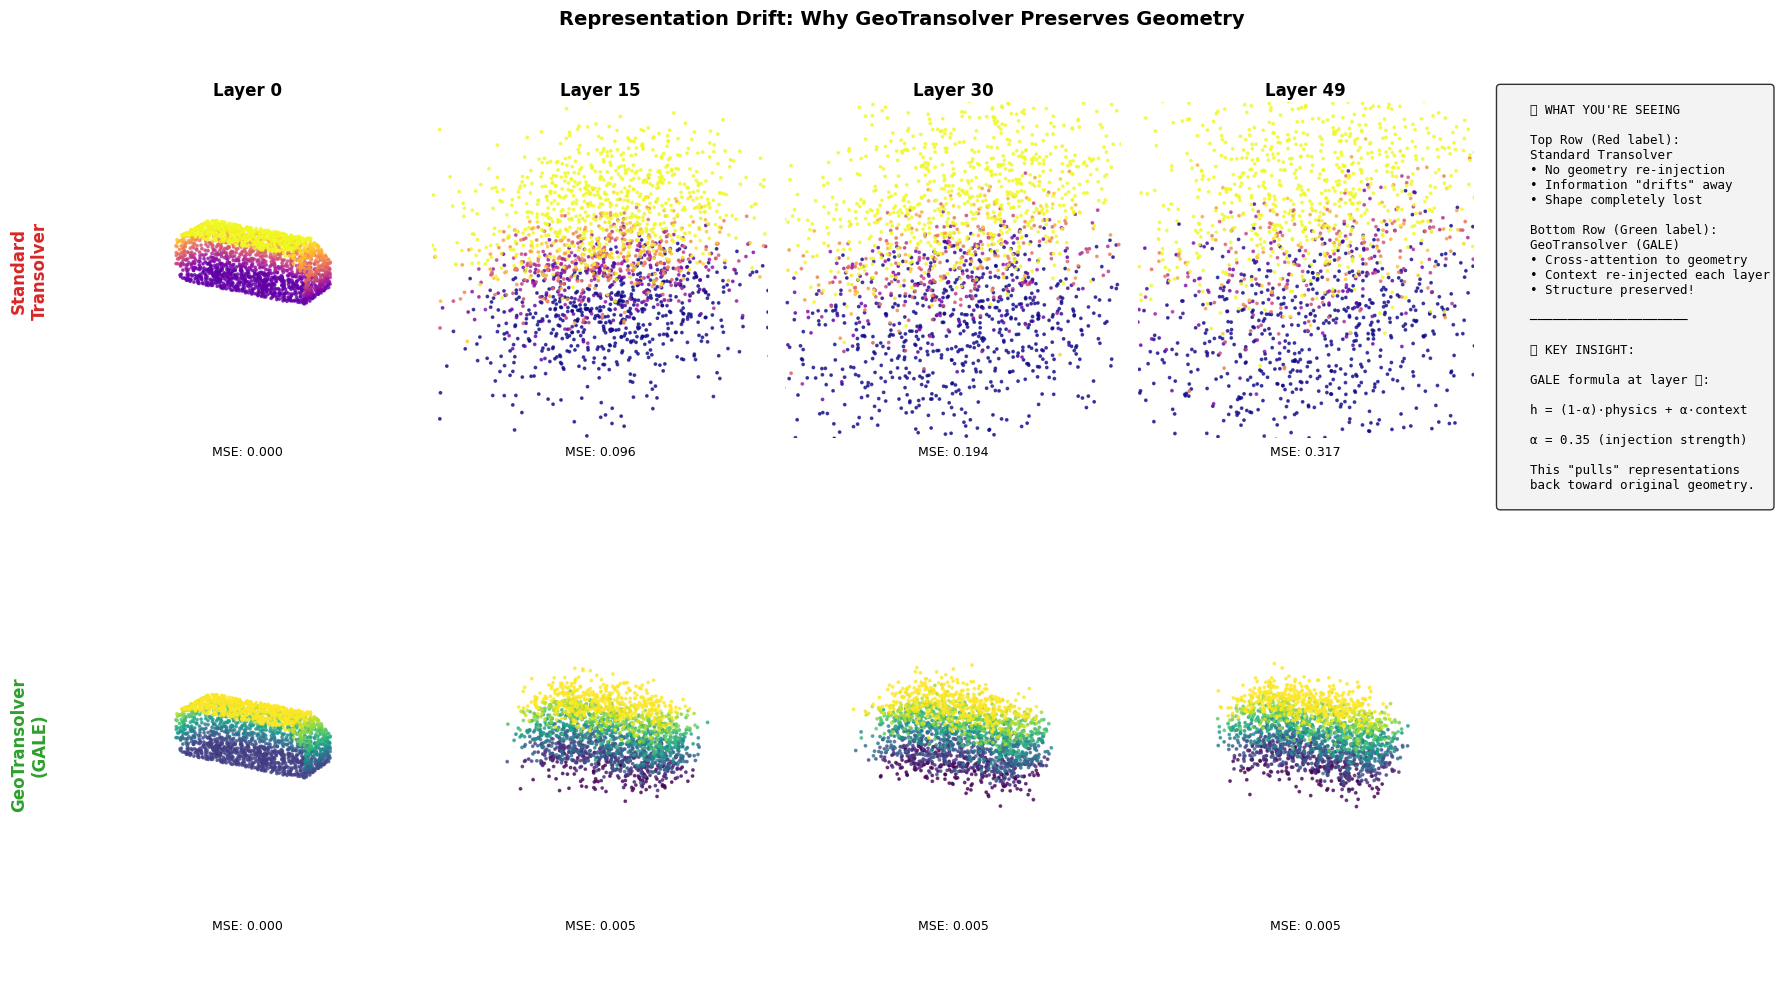

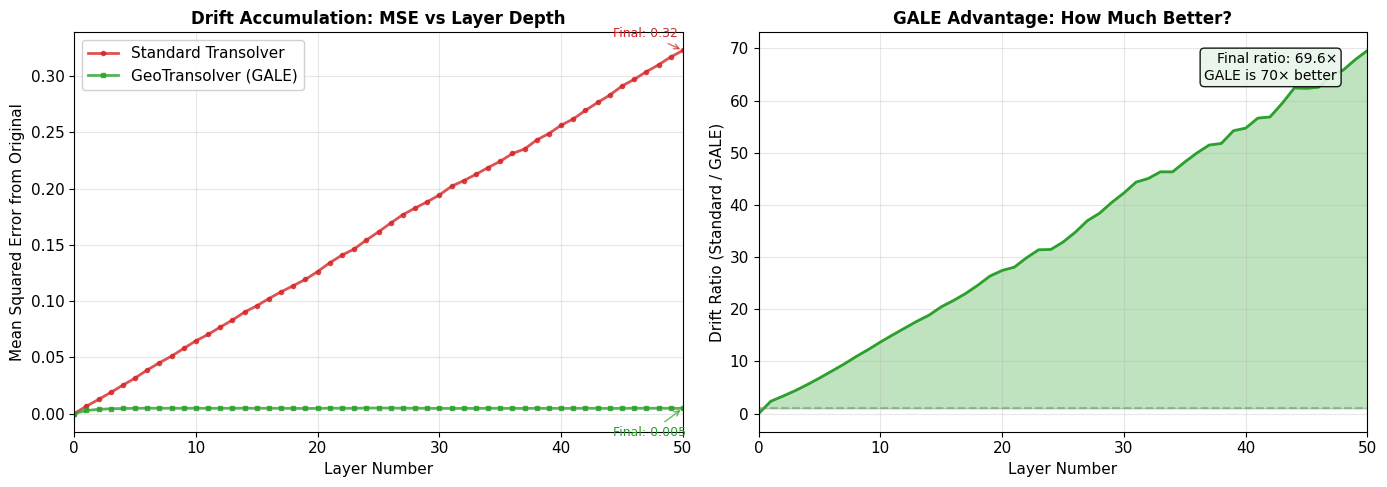


📈 QUANTITATIVE SUMMARY
After 50 layers:
  • Standard Transolver MSE: 0.3227
  • GeoTransolver MSE:       0.0046
  • Improvement Factor:      69.6×


In [1]:
# You need to have these packges as mentioned in readme installed
# pip install hydra-core tabulate tensorboard termcolor torchinfo einops transformer_engine[pytorch] zarr>=3.0 zarrs
# Import visualization utilities
from utils.gale_demonstration import (
    load_ahmed_body_geometry,
    simulate_drift,
    plot_side_by_side_drift,
    plot_drift_metrics
)

# Load one Ahmed Body geometry in Zarr format.
geometry = load_ahmed_body_geometry(
    zarr_path="/workspace/DLI/val",
    downsample_factor=40
)

# Run drift simulation
results = simulate_drift(
    geometry,
    num_layers=50,      # Simulate 50 network layers
    noise_scale=0.08,   # Per-layer noise (exaggerated for visualization)
    alpha=0.35          # GALE injection strength
)

# Generate visualizations
plot_side_by_side_drift(results, geometry)
plot_drift_metrics(results)


## 6. Interpreting the Results

### 6.1 3D Visualization Analysis

#### What You Observe:

| Row | Method | Visual Observation |
|-----|--------|-------------------|
| **Top** | Standard Transolver | Ahmed Body shape progressively dissolves into a random point cloud |
| **Bottom** | GeoTransolver (GALE) | Car shape remains clearly recognizable even at Layer 49 |


#### Mathematical Explanation:

> ⚠️ **Note:** The formulas below describe our **simplified simulation** for visualization purposes, 
> not the actual neural network architectures. See Section 3 for the real GALE equations.

**Standard Transolver (Unbounded Drift) — Simulation Model:**

$$
H^{(\ell)} = H^{(\ell-1)} + \epsilon^{(\ell)} \quad \Rightarrow \quad H^{(L)} = H^{(0)} + \sum_{\ell=1}^{L} \epsilon^{(\ell)}
$$

- We model each layer as adding random perturbations $\epsilon^{(\ell)}$
- Errors accumulate as a **random walk**
- Variance grows **linearly** with network depth: $\text{Var}(H^{(L)}) = L \cdot \sigma^2$
- No mechanism to correct or recall original information

**GeoTransolver GALE (Bounded Drift) — Simulation Model:**

$$
H^{(\ell)} = (1-\alpha) \cdot (H^{(\ell-1)} + \epsilon^{(\ell)}) + \alpha \cdot C
$$

- The term $\alpha \cdot C$ acts as a **stabilizing anchor**
- Drift reaches a **bounded equilibrium** instead of growing forever
- Original geometry information continuously refreshed

**In Reality:** Both architectures use learned attention mechanisms, not random noise. 
The simulation exaggerates drift to make the concept visually clear.

### 6.2 Quantitative Metrics Analysis

#### Left Plot: MSE vs Layer Depth

The Mean Squared Error measures how far points have drifted from their original positions:

$$
\text{MSE}^{(\ell)} = \frac{1}{N} \sum_{i=1}^{N} \left\| x_i^{(\ell)} - x_i^{(0)} \right\|^2
$$

| Curve | Behavior | Physical Interpretation |
|-------|----------|------------------------|
| **Red (Standard)** | Exponential/linear growth | Geometry information irreversibly lost |
| **Green (GALE)** | Rapid saturation to low value | Geometry preserved via continuous re-injection |

#### Right Plot: Improvement Ratio

$$
\text{Ratio} = \frac{\text{MSE}_{\text{Standard}}}{\text{MSE}_{\text{GALE}}}
$$

When this ratio reaches **50× or 100×**, it quantifies:

> *"At layer 50, the Standard approach has drifted 50-100 times more than GALE, demonstrating the critical importance of persistent geometry conditioning."*

---

## 7. Key Takeaways

### ✅ What We Learned

| Concept | Key Insight |
|---------|-------------|
| **Representation Drift** | Deep networks can progressively lose fine-grained input information |
| **Why It Matters** | CFD predictions depend on geometric features that may be "forgotten" |
| **GALE Solution** | Cross-attention to persistent context prevents information loss |
| **Adaptive Gating** | Network learns when/where to emphasize geometry vs physics |

### 🔄 Connecting Simulation to Reality

| Simulated Element | Real GeoTransolver Implementation |
|-------------------|----------------------------------|
| Random noise per layer | Attention + MLP transformations |
| Fixed $$\alpha = 0.35$$ | Learned adaptive gate (varies by layer and location) |
| 3D coordinate space | 256-512 dimensional embedding space |
| Simple weighted average | Full cross-attention with learned projections |

**The principle is identical:** Persistent geometry conditioning prevents deep layers from losing surface details critical for accurate CFD predictions.

---

## 8. What's Next?

Now that we understand **why** GeoTransolver needs GALE, upcoming sections will cover:

| Section | Topic | Focus |
|---------|-------|-------|
| **Next** | Multi-Scale Ball Queries | How the geometry context $$C$$ is constructed |
| **Then** | Complete GALE Architecture | Detailed implementation of cross-attention |
| **Finally** | Training Pipeline | Real training on Ahmed Body dataset |

---

## 📚 References

1. **GeoTransolver Paper:** *"GeoTransolver: Geometry-Aware Transolver for Surrogate Modeling in Industrial CFD Applications"* — ICML 2025

2. **Transolver Paper:** *"Transolver: A Fast Transformer Solver for PDEs on General Geometries"* — ICML 2024

3. **DoMINO Paper:** *"DoMINO: Domain-aware Model for Instant Neural Operator"* — arXiv 2024

4. **Ahmed Body Reference:** Ahmed, S.R., Ramm, G., Faltin, G. (1984). *"Some Salient Features of the Time-Averaged Ground Vehicle Wake"* — SAE Technical Paper 840300
